In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

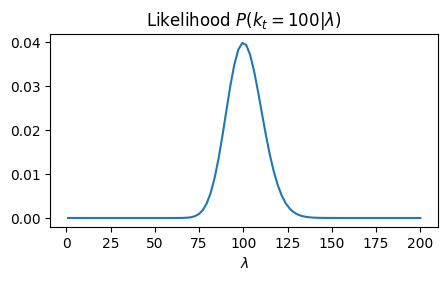

In [2]:
k = 100

lam = np.linspace(1, 200, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=100|\lambda\right)$', figsize=(5,2.5));

[[7.50299442e-08 2.71475854e-05 1.90391998e-09 ... 2.38732183e-12
  4.62308046e-17 4.83878843e-17]
 [7.74974093e-08 2.79463963e-05 2.02248272e-09 ... 3.04977431e-12
  6.34865315e-17 6.79753834e-17]
 [8.00431842e-08 2.87666733e-05 2.14821938e-09 ... 3.89128940e-12
  8.70641354e-17 9.53414842e-17]
 ...
 [6.96039248e-07 7.74521081e-19 3.60080241e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.64756031e-07 6.81678881e-19 3.08368074e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.34785232e-07 5.99788837e-19 2.63975394e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


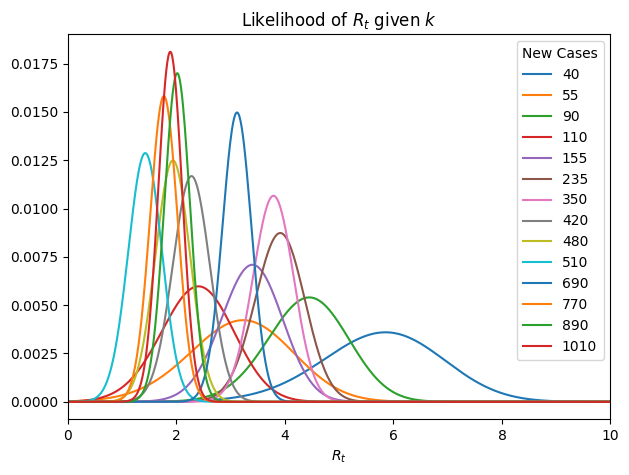

In [19]:
k = np.array([20, 40, 55, 90, 110, 155, 235, 350,420,480,510,690,770,890,1010])

# We create an array for every possible value of Rt
R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
# print(r_t_range)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))
# print(lam)

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(7,5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

# print(k[:-1])
print(likelihood_r_t)

<bound method DataFrame.idxmax of Day             1             2             3             4             5   \
0.00  1.302869e-07  3.646839e-09  1.832876e-15  9.919674e-17  1.989532e-23   
0.01  1.345716e-07  3.877607e-09  2.070220e-15  1.172702e-16  2.560961e-23   
0.02  1.389922e-07  4.122539e-09  2.337821e-15  1.385863e-16  3.294676e-23   
0.03  1.435530e-07  4.382476e-09  2.639475e-15  1.637175e-16  4.236233e-23   
0.04  1.482581e-07  4.658306e-09  2.979442e-15  1.933355e-16  5.443820e-23   
...            ...           ...           ...           ...           ...   
5.96  6.216310e-03  2.257066e-04  3.354163e-05  2.684362e-11  2.682088e-16   
5.97  6.210534e-03  2.171813e-04  3.128553e-05  2.256078e-11  2.043798e-16   
5.98  6.204247e-03  2.089260e-04  2.916727e-05  1.894513e-11  1.555375e-16   
5.99  6.197452e-03  2.009344e-04  2.717942e-05  1.589539e-11  1.182126e-16   
6.00  6.190149e-03  1.932001e-04  2.531494e-05  1.332521e-11  8.972693e-17   

Day             6            

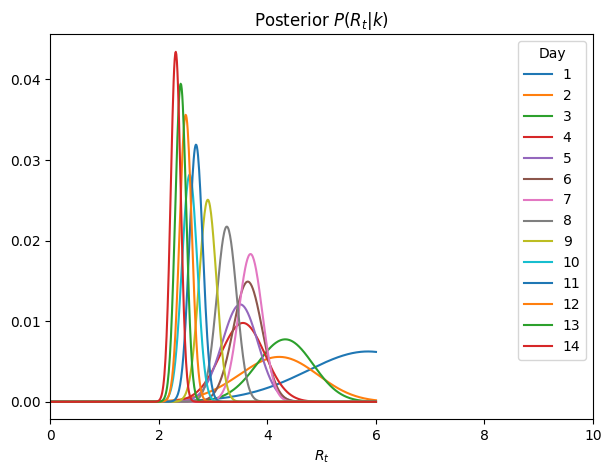

In [12]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(7,5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');


In [13]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1     5.85
2     4.22
3     4.33
4     3.55
5     3.50
6     3.64
7     3.69
8     3.25
9     2.90
10    2.57
11    2.68
12    2.49
13    2.40
14    2.31
dtype: float64

In [35]:
def highest_density_interval(pmf, p=.95, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi

,Low_95,High_95
Day,,
1,3.54,7.90
2,2.70,5.53
3,3.28,5.30
4,2.72,4.32
5,2.80,4.10
6,3.09,4.14
7,3.23,4.09
8,2.88,3.60
9,2.56,3.19


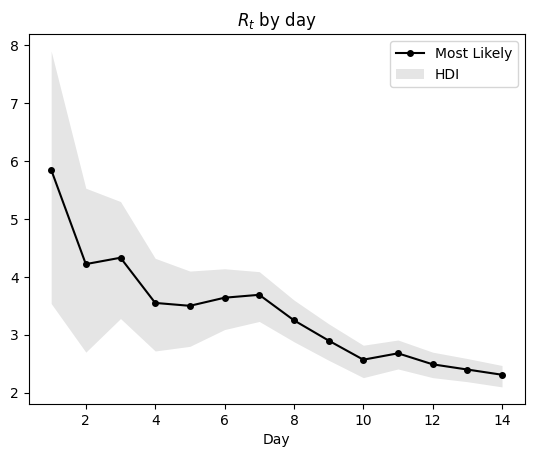

In [23]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_95'],
                hdi['High_95'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();